<img style="float: right;" src="https://www.h-ka.de/typo3conf/ext/in2template/Resources/Public/Images/Icons/Favicons/favicon-256x256.png">

# Simple Classification

In this exercise you implement simple classification methods, not using any neural networks.

The idea is to learn the possibilities of those mechanisms but also gain an understanding of the limited character of those simple mechanisms.

The exercise consist of three parts:
1. simple threshold classification (with $p=1$ dimensions)
2. shortest distance classification (with $p=2$ dimensions)
3. k nearest neightbour (knn) (with $p=3$ dimensions)

For all parts 2 classes ($q=2$) are used.

The code is intended for the lecture "[Neuronale Netze in Bildverarbeitung](https://www.h-ka.de/fileadmin/Hochschule_Karlsruhe_HKA/Informationsmaterialien/HKA_FK-EIT_Sem7_NeuronaleNetze_01.pdf)" at HKA.

## Student Details:

- FirstName: Jan
- LastName: Hoegen
- MatriculationNumber: 82358
----------

In [99]:
#####################
# DON'T CHANGE THE CODE
#####################

# some init stuff
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
#####################
# DON'T CHANGE THE CODE
#####################

############################
# generate some 3D random toy data
train_samples=2000  # We are going to use these data point for the "training"
test_samples=500    # We'll use these data points to evaluate how good our classification works
np.random.seed(0)   # Note: we set the random seed to '0' for repeatable experiments.

# Note: The toy data that we are going to create will consist of
# - data points (x) and
# - a corresponding label (y) that represents the true class of the data point

# First we create y_train that contains the training labels
y_train=np.zeros((int(train_samples)))
y_train[0:int(1*train_samples/2)]+=1 # class 1
y_train[int(1*train_samples/2):int(train_samples)]+=2 # class 2
# As you can see, this gives you a vector with 1s and 2s.
# What is the size of y_train?

# X_train contains the training data
# We use a 3d gauss distribition to create the data points, as we just want some data to play with
# The distribution has no mean value, hence we be zero centered.
# The variance is 2 for each dimension, the covariance is 0 hence we have uncorrelated data.
mean = [0, 0, 0] # mean value
cov = [[2, 0, 0],
       [0, 2, 0],
       [0, 0, 2]] # diagonal covariance
x1, x2, x3 = np.random.multivariate_normal(mean, cov, train_samples).T
# Later we want to seperate class 1 and class 2, therefore we need to add a possible discrimination.
# Therefore we shift the data points of class 2 with +5 in each dimension.
x1[y_train==2]+=5
x2[y_train==2]+=5
x3[y_train==2]+=5
X_train = np.array([x1, x2, x3]) #combine the three dimension to one variable
# What is the size of x_train?

############################
# The same we do for the test data, note that the test data have a slightly different variance and shift.
# y_test contains the test labels
y_test=np.zeros((int(test_samples)))
y_test[int(0*test_samples/2):int(1*test_samples/2)]+=1 # class 1
y_test[int(1*test_samples/2):int(2*test_samples/2)]+=2 # class 2

# X_test contains the test data
mean = [0, 0, 0] # mean value
cov = [[2.5, 0  , 0],
       [0  , 2.5, 0],
       [0  , 0  , 2.5]] # diagonal covariance
x1, x2, x3 = np.random.multivariate_normal(mean, cov, test_samples).T
x1[y_test==2]+=4.8 # separate class 1 from class 2 in the toy data
x2[y_test==2]+=4.9
x3[y_test==2]+=5.3
X_test = np.array([x1, x2, x3])

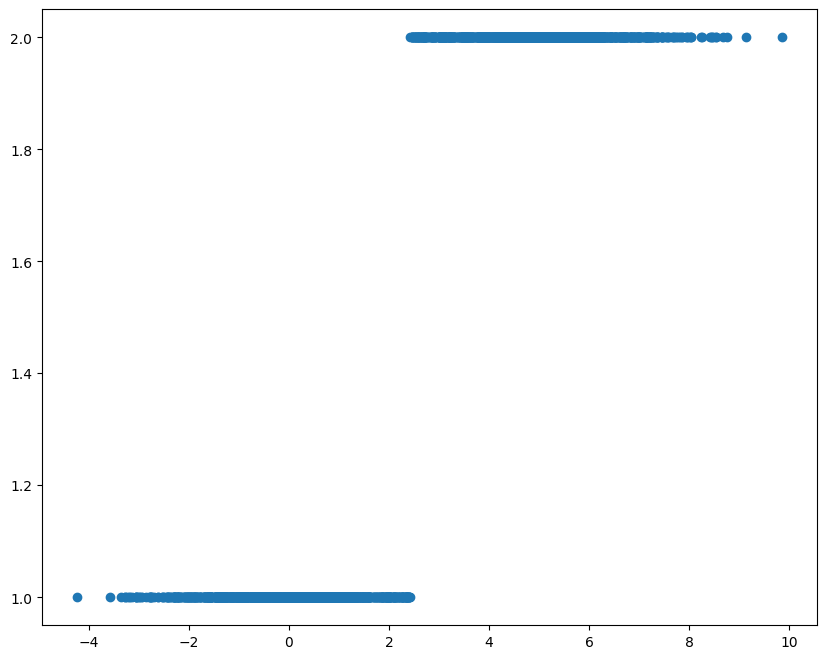

In [101]:
plt.scatter(np.sort(X_train[0]), y_train)

## What is stored in the training/test data (X) and the training/test (Y) label?

Well, first of all you need to understand it includes only toy-data.

The toy-data is simply a normal distribution over three dimensions ($x_1$, $x_2$, $x_3$) with the variables ``train_samples`` or ``test_samples`` as the amount of sample points.<br>
To discriminate the two classes, half of the data points are shifted using the mean values $x_1$, $x_2$, $x_3$.

To identify the matching data points that belong to a class the labels in ``y_train`` and ``y_test`` are used.
We want to keep it simple so we define that the half of the labels belong to class 1 and the other half belongs to class 2.

Lets have a look, how the train data and labels looks like:

In [102]:
# We have the following train labels
print("Train labels: ", y_train[:2], " ... " ,  y_train[998:1002], " ... ", y_train[1997:2000])
print()

# The following data points in x1 belong to those labels
print("Train data: ", X_train[0,0:2], " ... " ,  X_train[0,998:1002], " ... ", X_train[0,1997:2000])
print()

# The following data points in x2 belong to those labels
print("Train data: ", X_train[1,0:2], " ... " ,  X_train[1,998:1002], " ... ", X_train[1,1997:2000])
print()

# The following data points in x3 belong to those labels
print("Train data: ", X_train[2,0:2], " ... " ,  X_train[2,998:1002], " ... ", X_train[2,1997:2000])
print()

# This means we have 2000 three dimensional data points in X_train
# To every data point we have a label in y_train
# If we want to find a label that belongs to a data point, e.g. X_train[0,5] it can be simply read out by using
print("Data point: ", X_train[0,5], " is from class: " , y_train[X_train[0,:]==X_train[0,5]])
find_idx=X_train[0,:]==X_train[0,5]
print("This boolean test is done to get a true statement at the correct index and find the classlabel in the Y vector: \n",
      "To show you the principle here are the first nine results to find the correct class label:",find_idx[0:8])

Train labels:  [1. 1.]  ...  [1. 1. 2. 2.]  ...  [2. 2. 2.]

Train data:  [2.49474675 3.16910155]  ...  [ 0.4525935  -0.27210064  7.25322916  5.35585891]  ...  [4.98414079 4.42304072 4.23931609]

Train data:  [0.56590775 2.64112584]  ...  [ 2.94039984 -1.71475621  5.80429493  3.28759153]  ...  [6.90177839 3.1179591  5.55641445]

Train data:  [ 1.38414453 -1.38207963]  ...  [-1.2833507  -0.11398351  4.83809087  4.44317644]  ...  [3.82409217 5.49864975 5.40519802]

Data point:  0.4718867591884083  is from class:  [1.]
This boolean test is done to get a true statement at the correct index and find the classlabel in the Y vector: 
 To show you the principle here are the first nine results to find the correct class label: [False False False False False  True False False]


## Simple 1D threshold classification

Using a simple one dimensional **(1D) threshold value**, it is possible classify data into **two classes**.
All values **below** the threshold could be classified as **class 1**, all values **above** the threshold could be classified as **class 2**.

Lets see how our data looks along one dimension.
Class 1 is shown in red, class 2 is shown in blue.

Note:
- The separation of the data is done by using the labels in y_train
- You can choose the dimension by changing the variable **x_dim**.

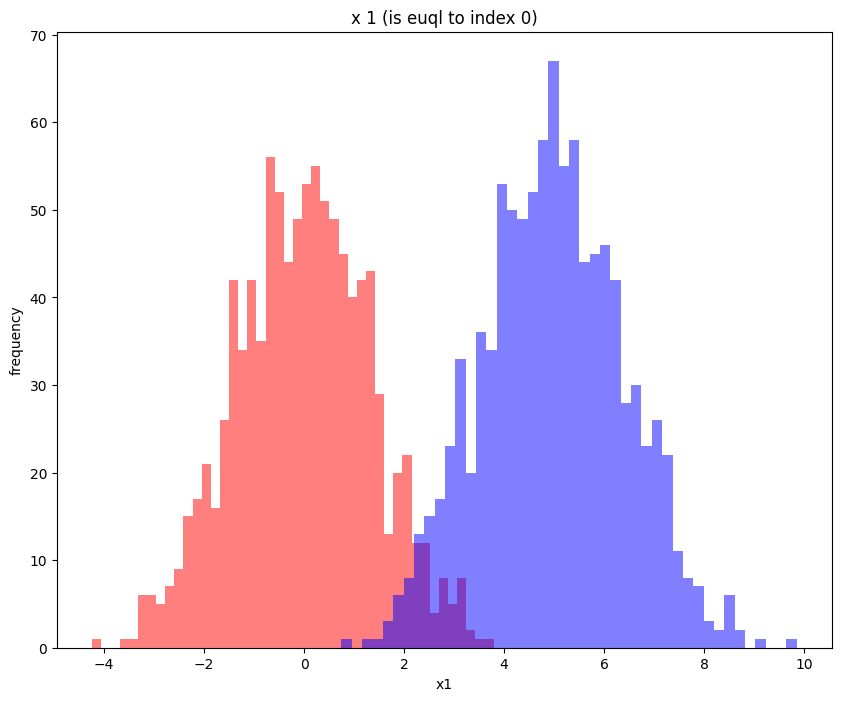

In [103]:
# Define dimension
x_dim=1 -1

# Analyze training data
plt.hist(X_train[x_dim,y_train==1], bins=int(np.sqrt(train_samples)), facecolor='r', alpha=0.5) # show class 1
plt.hist(X_train[x_dim,y_train==2], bins=int(np.sqrt(train_samples)), facecolor='b', alpha=0.5) # show class 2
plt.title(f"x {x_dim+1} (is euql to index {x_dim})")
plt.xlabel("x"+str(x_dim+1))
plt.ylabel("frequency")

# plt.xlim((2.4, 2.5))
plt.show()

As you can see, the data approximately follows a **gaussian distribution** for each class.
This is what we expected as the toy-data is generated using a multivariate gaussian distribution.

Now, if we want to classify the data we need to **determine** the threshold value.

We could use some fancy optimization here, but we want to keep it simple and just **search** for the threshold **k** over the complete range in our selected dimension x_dim (which is OK, as we just have a few data points).

From examining the plot above we expect the optimal k to be somewhere between 2...3.
If you don't share this **intuition** for k, you should examine the plot above a bit more.

In [104]:
# Example implementation for finding an optimal threshold k using a seach over
# the complete range of the selected dimension.

# Notice: Such a method is brute-force like and should not be used with bigger data sets.
# Nevertheless it is a good example to understand the threshold search.

# First we define the search area for 1D threshold k
k_min=np.min(X_train[x_dim,:]) # search from the minimum
k_max=np.max(X_train[x_dim,:]) # to the maximum of the selected x_dim

print(f"k min: {k_min}\nk max: {k_max}")

# Prepare the search for k
m = int(1e2)
i=0 # init of the index variable
loss=np.zeros((m,1)) # init of the loss, notice that we calculate m possible loss values.
y_predict=np.zeros((int(train_samples))) # init the prediction vector

# we want to search for the optimal k over m possible values ranging from k_min to k_max
k_pot=np.linspace(k_min, k_max, num=m).reshape(m,1)
print(k_pot.shape)

# Search an optimal 1D threshold for classification
for k in k_pot:
        y_predict[X_train[x_dim,:]>k]=2   # for all X_train values > k we predict class 2
        y_predict[X_train[x_dim,:]<=k]=1  # for all X_train values <= k we predict class 1
        # The loss provides an objective number how bad the classification worked.
        loss[i]=sum((y_predict!=y_train))
        i+=1

# select optimal k
k_optimal=k_pot[loss==min(loss)] # here we find the optimal k for the minimum loss
print("k optimal=",k_optimal, "identisch zu ", k_pot[np.argmin(loss)])
print('min_loss=', 100*min(loss)/train_samples, "%")

k min: -4.235022120990784
k max: 9.847271498727498
(100, 1)
k optimal= [2.30826582] identisch zu  [2.30826582]
min_loss= [3.35] %


Your minimum training loss should be 3,35% for x_dim=0

Lets see how the loss changes if we vary k:

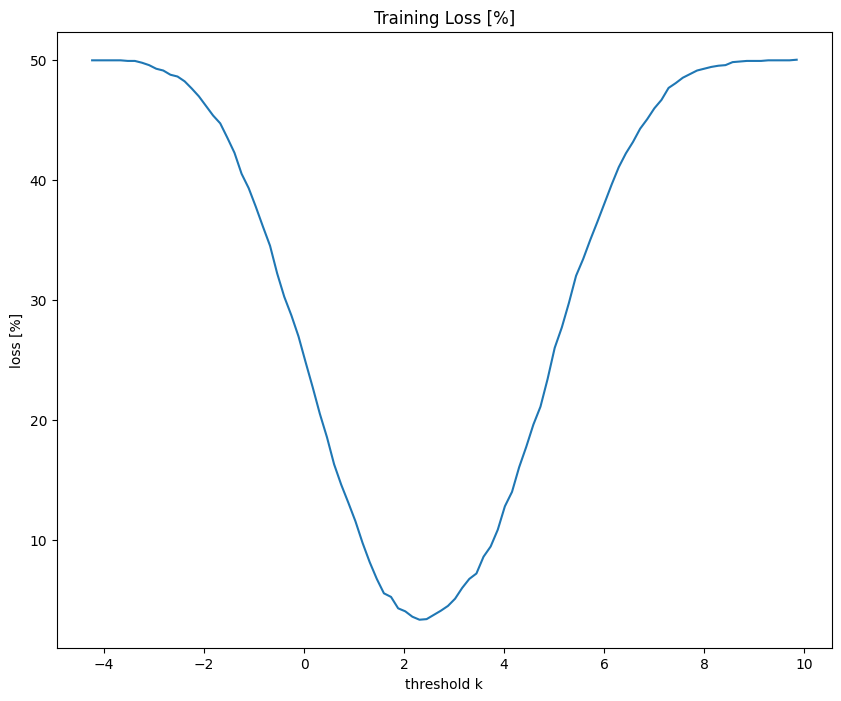

In [105]:
plt.plot(k_pot, 100*loss/train_samples)
plt.title("Training Loss [%]")
plt.xlabel("threshold k")
plt.ylabel("loss [%]")
plt.show()

**Inline Question 1**

Notice the minimal value of the loss function. Is a perfect separation possible?

> Perfekte Klassifikation mit $Loss=0$ ist ausschließlich für $x_2$ möglich, wenn die Stepsize für k groß genug (1e5) gewählt wird. Die Histogramme für $x_1$ und $x_3$ zeigen eine Überschneidung der x-Werte.

**Inline Question 2**

Is a separation possible in one of the other dimensions?

> siehe oben

**Now implement the linear 1D classification using the test data**

In the above implementation we used the training data to find an optimal k.
In reality we would expect that our training data points are highly correlated with the data that we want to classify in our application.

What you need to do is to classify the test data using the optimal k you derived from the training data and calculate the loss made.

In [107]:
#####################
# Your implementation
#####################

# ! The following applies the test data!
y_predict = np.zeros((int(test_samples)))
y_predict[X_test[x_dim,:]>k_optimal]=2   # for all X_train values > k we predict class 2
y_predict[X_test[x_dim,:]<=k_optimal]=1
loss = sum(y_predict != y_test)


#####################
print('k optimal=',k_optimal)
print('min_loss=', 100*loss/test_samples, "%")

k optimal= [2.30826582]
min_loss= 6.8 %


Your test loss should be 6,8% for x_dim=0.

In [108]:
print(f"Size difference training to test data: {train_samples/test_samples}")

Size difference training to test data: 4.0


**Inline Question 3**

Please explain the differences between test and training data.

> - The training data is 4 times larger
> - the covariance is 2.5 instead of 2 on the diagonal when creating the normal distribution
> - the x axis data points are right shifted by (4.8, 4.9, 5.2) instead of 5 for the training data

## 2D shortest distance classification

In the lecture we discussed the shortest distance classification.

For this method a **center of mass** point is calculated for **each cluster**.

Notice: The calculation of the center of mass is the complete training phase!

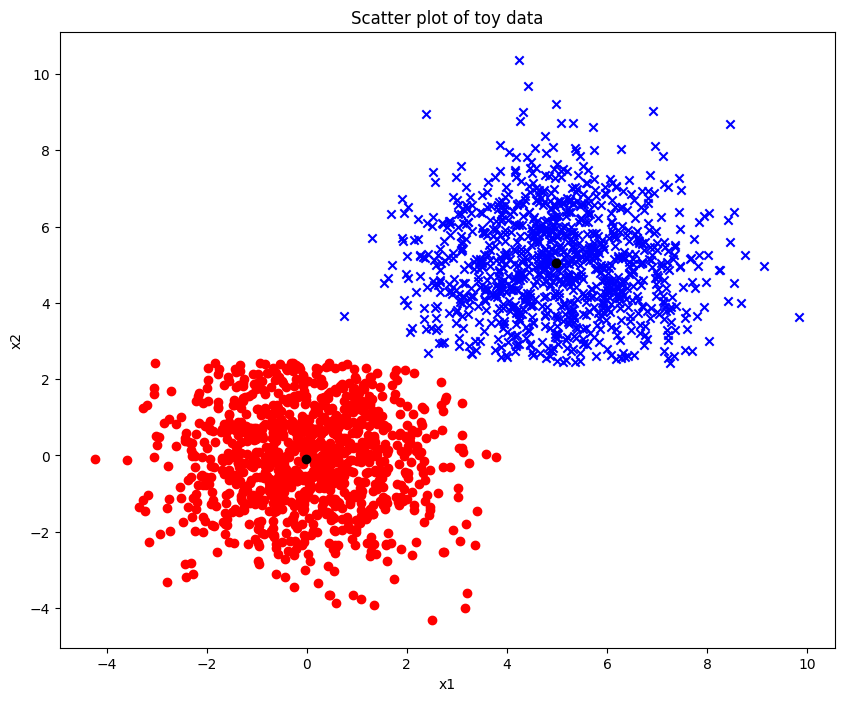

In [ ]:
# Define dimension
x_dim1=0
x_dim2=1

# calculate 2D center of mass for the training data of class 1
class1_mean_x1=np.mean(X_train[x_dim1,y_train==1])
class1_mean_x2=np.mean(X_train[x_dim2,y_train==1])
m_q1= np.array([class1_mean_x1, class1_mean_x2])

# calculate 2D center of mass for the training data of class 2
class2_mean_x1=np.mean(X_train[x_dim1,y_train==2])
class2_mean_x2=np.mean(X_train[x_dim2,y_train==2])
m_q2= np.array([class2_mean_x1, class2_mean_x2])

# analyze the toy data
fig = plt.figure()
ax = fig.add_subplot(111)
# plot class 1
ax.scatter(X_train[x_dim1,y_train==1],
           X_train[x_dim2,y_train==1],
           c='r', marker='o')
# plot class 2
ax.scatter(X_train[x_dim1,y_train==2],
           X_train[x_dim2,y_train==2],
           c='b', marker='x')
# plot center of mass for class 1
ax.scatter(m_q1[0],
           m_q1[1],
           c='k', marker='o')
# plot center of mass for class 2
ax.scatter(m_q2[0],
           m_q2[1],
           c='k', marker='o')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.title("Scatter plot of toy data")
plt.show()

The classification is done by calculating the euclidian distance to the center of mass of each data point to classify and select the shortest distance.

In [113]:
test = np.array([[1,2], [3,4]])
print(test)
print(test[0])

[[1 2]
 [3 4]]
[1 2]


In [119]:
# # Implementation of the 2D shortest distance classification

# y_predict=np.zeros((int(train_samples)))

# #####################
# # ... TODO ...
# # get rid of the loop!
# #####################

# for sample in range(train_samples):
#     dist_m_q1 = np.linalg.norm(X_train[[x_dim1, x_dim2],sample]-m_q1)
#     dist_m_q2 = np.linalg.norm(X_train[[x_dim1, x_dim2],sample]-m_q2)
#     if dist_m_q1 < dist_m_q2:
#         y_predict[sample]=1
#     else:
#         y_predict[sample]=2

        
# # meine lösung
dist_m_q1 = np.sqrt((class1_mean_x1 - X_train[x_dim1])**2 + (class1_mean_x2 - X_train[x_dim2])**2)
dist_m_q2 = np.sqrt((class2_mean_x1 - X_train[x_dim1])**2 + (class2_mean_x2 - X_train[x_dim2])**2)
y_predict = np.where(dist_m_q1 < dist_m_q2,1, 2)

loss=sum((y_predict!=y_train))
print('loss=', 100*loss/train_samples, "%")

loss= 0.7 %


Your training loss should be 0,7% for x_dim1=0, x_dim2=1.

**Now implement the linear 2D shortest distance classification using the test samples**

After the training, we want to see how our classification performs with new data (the test data).
For the classification, the center of mass points for the classes from the training are used, and the distances to test data points are calulated.

Notice: Do not calculate a new center of mass for the test data! Use the center of mass that was derived during the training phase.

In [ ]:
#####################
# Your implementation
# ... TODO ...
#####################


#####################
loss=sum((y_predict!=y_test))
print('loss=', 100*loss/test_samples, "%")

ValueError: operands could not be broadcast together with shapes (2000,) (500,) 

Your test loss should be 1,2% for x_dim1=0, x_dim2=1.

**Now implement the linear 3D shortest distance classification using the training samples**

In the above cells, we only used two dimensions for the localization of the center of mass.
As our training and test data has three independent dimensions we should use all of them to get a better classification result.

The implementation is very similar to the 2D distance.
The difference is that
- the center of mass for both classes and
- the euclidean distance to each data point

are now calculated for all three dimensions.

In [ ]:
#####################
# Your implementation
# ... TODO ...
#####################

#####################
loss=sum((y_predict!=y_train))
print('loss=', 100*loss/train_samples, "%")

Your test loss should be 0,15%.

**Now implement the linear 3D shortest distance classification using the test samples**

In [ ]:
#####################
# Your implementation
# ... TODO ...
#####################


#####################
loss=sum((y_predict!=y_test))
print('loss=', 100*loss/test_samples, "%")

Your training loss should be 0,6%.

## 3D knn classification

In this method we calculate the distance from the test data points to the training points.

The classification is then done by assigning the majority of the k nearest neighbour classes.

Let's have a look how our data looks:

In [ ]:
# analyze the toy train data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[0,y_train==1],
           X_train[1,y_train==1],
           X_train[2,y_train==1],
           c='r', marker='o')

ax.scatter(X_train[0,y_train==2],
           X_train[1,y_train==2],
           X_train[2,y_train==2],
           c='b', marker='x')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
plt.title("Scatter plot of toy train data")
plt.show()

**Now implement the linear 3D knn classification using the test data**

Notice: The training is done by just having all the training data points available.

In [ ]:
#####################
# Your implementation
# ... TODO ...
#####################


#####################
loss=sum((y_predict!=y_test))
print('loss=', 100*loss/test_samples, "%")

Your loss should be 0,4% for knn=5.